<a href="https://colab.research.google.com/github/JazmineOrtizMarin/Simulaci-n-2/blob/main/Muestreo_Importancia_Crudo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Muestreo Importancia**

Se implementa el **método de muestreo por importancia** (*Importance Sampling*)  para estimar la integral de una función difícil de evaluar directamente mediante Monte Carlo crudo.


El método de Monte Carlo básico estima una integral del tipo:

$$I = \int_a^b f(x)\,dx$$

aproximándola como un promedio de valores de **f(x)** evaluados en puntos aleatorios **x_i** uniformes:

$$I \approx \frac{b-a}{n} \sum_{i=1}^{n} f(x_i), \qquad x_i \sim U(a,b)$$

Sin embargo, cuando **f(x)** tiene regiones donde contribuye más fuertemente (por ejemplo, picos), este método puede ser ineficiente, ya que gasta muchas muestras en zonas de poca relevancia.

Para mejorar la eficiencia, se introduce una *función de densidad de probabilidad auxiliar* **g(x)**,
de la cual sea fácil generar muestras, y que se parezca en forma a **f(x)**.

El principio es reescribir la integral como:

$$I = \int_a^b f(x)\,dx = \int_a^b \frac{f(x)}{g(x)}\, g(x)\, dx = \mathbb{E}_g\!\left[\frac{f(X)}{g(X)}\right]$$

donde $$X \sim g(x)$$

Entonces, el estimador de Monte Carlo con muestreo por importancia es:

$$\hat{I} = \frac{1}{n} \sum_{i=1}^{n} \frac{f(x_i)}{g(x_i)}, \qquad x_i \sim g(x)$$

Si **g(x)** se elige adecuadamente, este método *reduce la varianza* del estimador y mejora la eficiencia.


In [187]:
# Librerías
import numpy as np
import matplotlib.pyplot as plt
import random as rd

En el código se definen dos funciones:

- **Función objetivo:**

$$f(x) = \cos\!\left(\frac{\pi x}{2}\right)$$

- **Función de importancia:**

$$g(x) = \frac{24}{24-\pi^2} \left( 1 - \frac{\pi^2 x^2}{8} \right)$$

Esta **g(x)** es una función no negativa que integra aproximadamente a **1** en el intervalo **[0,1]**,
por lo que puede servir como una **densidad de probabilidad válida** para generar muestras.

El factor de normalización $$\frac{24}{24-\pi^2}$$ asegura que:

$$\int_0^1 g(x)\,dx \approx 1$$

In [188]:
# Función Objetivo:
def f(x):
  f = np.cos((x*np.pi)/2)
  return f

In [189]:
# Función de Importancia:
def g(x):
  g = (24/(24-np.pi**2)) * (1-((np.pi**2) * (x**2)) / 8)
  return g

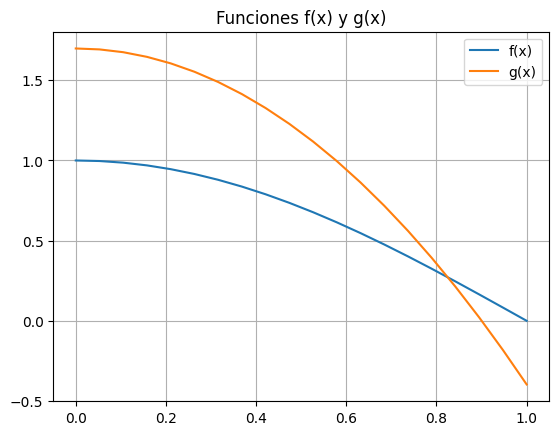

In [190]:
plt.title("Funciones f(x) y g(x)")
xx = np.linspace(0,1,20)
plt.plot(xx,f(xx), label='f(x)')
plt.plot(xx,g(xx), label='g(x)')
plt.legend()
plt.grid()
plt.show()

Se implementó la función `muestra_g(n)` para generar números aleatorios
conforme a la distribución **g(x)** mediante el método de **Aceptación y Rechazo**.

El procedimiento es:

1. Se genera $$u \sim U(0,1)$$  
2. Se genera $$w \sim U(0,c)$$ donde $$c = \frac{24}{24-\pi^2}$$ es el valor máximo de **g(x)**.  
3. Si $$w \le g(u)$$, se acepta el punto **u**; en caso contrario, se rechaza.  
4. Se repite hasta obtener **n** muestras.

En forma resumida:

$$\text{Aceptar } u \text{ si } w \le g(u).$$

Las muestras aceptadas conforman el conjunto **M**, que sigue la distribución **g(x)**.

In [191]:
def muestra_g(n):
  c = 24 / (24-np.pi**2)
  lista = []
  for i in range(n):
    u = rd.random()
    w = rd.uniform(0,c)
    if w <= g(u):
      lista.append(u)
  return lista

In [192]:
M = muestra_g(1000)

Generando muestras con g(x)


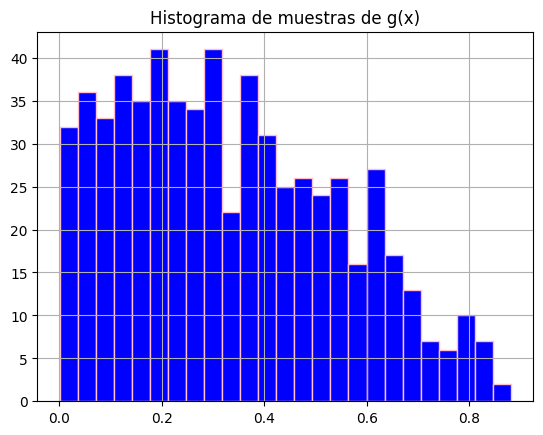

In [193]:
# Histograma
print("Generando muestras con g(x)")
M = muestra_g(1000)
plt.hist(M, bins=25, color='blue', edgecolor='pink')
plt.title("Histograma de muestras de g(x)")
plt.grid()
plt.show()

In [194]:
def crudo(N):
  G=[]
  u = muestra_g(N)
  for i in u:
    G.append(f(i)/g(i))
  return np.mean(G), np.var(G), np.std(G)

In [196]:
print("Estimación por Muestreo por Importancia:")
print("----------------------------------------")
media, var, std = crudo(1000)
print(f"Media estimada: {media:.10f}")
print(f"Varianza:       {var:.10f}")
print(f"Desviación:     {std:.10f}")
print(f"Valor real:     {2/np.pi:.10f}")

Estimación por Muestreo por Importancia:
----------------------------------------
Media estimada: 0.6105350791
Varianza:       0.0048203035
Desviación:     0.0694284058
Valor real:     0.6366197724
